# Modelling
I actually forgot what the purpose of this notebook. I'll find it later. :)

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

# Load Things

In [2]:
trainX_first = np.load('outputs/train_x_first_v2.npy')
trainY_first = np.load('outputs/train_y_first_v2.npy')

trainX_second = np.load('outputs/train_x_second_v2.npy')
trainY_second = np.load('outputs/train_y_second_v2.npy')

In [3]:
df_first = pd.read_csv('dataset/firsthalf_v2.csv')
df_second = pd.read_csv('dataset/secondhalf_v2.csv')

In [4]:
total_samples_first = trainX_first.shape[0]
split_index_first = int(total_samples_first * 0.9)

total_samples_second = trainX_second.shape[0]
split_index_second = int(total_samples_second * 0.9)

In [5]:
n_future = 1   # Number of data we want to look into the future based on the past data.
n_past = 24  # Number of past data we want to use to predict the future.

In [6]:
true_value_first = df_first['traffic_volume'][split_index_first+n_past:].values
true_value_second = df_second['traffic_volume'][split_index_second+n_past:].values

In [7]:
import joblib
scaler_first = joblib.load('outputs/MM_scaler_first_v2.joblib')
scaler_second = joblib.load('outputs/MM_scaler_second_v2.joblib')

# Train test Split

In [8]:
total_samples_first = trainX_first.shape[0]
split_index_first = int(total_samples_first * 0.9)

X_train_first = trainX_first[:split_index_first]
y_train_first = trainY_first[:split_index_first]
X_test_first = trainX_first[split_index_first:]
y_test_first = trainY_first[split_index_first:]

In [9]:
total_samples_second = trainX_second.shape[0]
split_index_second = int(total_samples_second * 0.9)

X_train_second = trainX_second[:split_index_second]
y_train_second = trainY_second[:split_index_second]
X_test_second = trainX_second[split_index_second:]
y_test_second = trainY_second[split_index_second:]

In [10]:
print(f'X_train_first length == {len(X_train_first)}')
print(f'X_test_first length == {len(X_test_first)}')

print(f'X_train_second length == {len(X_train_second)}')
print(f'X_test_second length == {len(X_test_second)}')

X_train_first length == 14552
X_test_first length == 1617
X_train_second length == 15231
X_test_second length == 1693


# BiLSTM

In [11]:
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense

## First Half Dataset

In [ ]:
from kerastuner.tuners import RandomSearch

def build_model_BiLSTM(hp):
    model = Sequential()
    model.add(Bidirectional(LSTM(hp.Int('units_layer1', min_value=32, max_value=128, step=32),
                                activation=hp.Choice('activation', values=['relu', 'tanh']),
                                input_shape=(trainX_first.shape[1], trainX_first.shape[2]),
                                return_sequences=True)))
    model.add(Bidirectional(LSTM(hp.Int('units_layer2', min_value=16, max_value=64, step=16), activation='relu')))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(trainY_first.shape[1]))
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop']),
                  loss='mae')
    return model

In [ ]:
tuner_BiLSTM = RandomSearch(
    build_model_BiLSTM,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='model/BiLSTM_first',
    project_name='BiLSTM_tuning_first'
)

tuner_BiLSTM.search(X_train_first, y_train_first, epochs=10, validation_data=(X_test_first, y_test_first))

Trial 10 Complete [00h 19m 43s]
val_loss: 0.04882329702377319

Best val_loss So Far: 0.043757239977518715
Total elapsed time: 02h 31m 14s


In [ ]:
# Get the optimal hyperparameters
best_hps_BiLSTM_first = tuner_BiLSTM.get_best_hyperparameters(num_trials=1)[0]

for param in best_hps_BiLSTM_first.values:
    print(param, best_hps_BiLSTM_first.get(param))

units_layer1 128
activation tanh
units_layer2 48
dropout 0.1
optimizer rmsprop


In [ ]:
# Build the model with the best hyperparameters
model_BiLSTM_tuned_first = tuner_BiLSTM.hypermodel.build(best_hps_BiLSTM_first)
history_BiLSTM_tuned_first = model_BiLSTM_tuned_first.fit(trainX_first, trainY_first, epochs=50, validation_data=(X_test_first, y_test_first))

Epoch 1/50
506/506 [==============================] - 35s 54ms/step - loss: 0.1145 - val_loss: 0.1027
Epoch 2/50
506/506 [==============================] - 27s 53ms/step - loss: 0.0711 - val_loss: 0.0641
Epoch 3/50
506/506 [==============================] - 27s 53ms/step - loss: 0.0577 - val_loss: 0.0585
Epoch 4/50
506/506 [==============================] - 27s 54ms/step - loss: 0.0519 - val_loss: 0.0451
Epoch 5/50
506/506 [==============================] - 27s 54ms/step - loss: 0.0475 - val_loss: 0.0454
Epoch 6/50
506/506 [==============================] - 28s 55ms/step - loss: 0.0456 - val_loss: 0.0726
Epoch 7/50
506/506 [==============================] - 29s 56ms/step - loss: 0.0440 - val_loss: 0.0504
Epoch 8/50
506/506 [==============================] - 30s 59ms/step - loss: 0.0424 - val_loss: 0.0432
Epoch 9/50
506/506 [==============================] - 29s 58ms/step - loss: 0.0417 - val_loss: 0.0376
Epoch 10/50
506/506 [==============================] - 30s 59ms/step - loss: 0.040

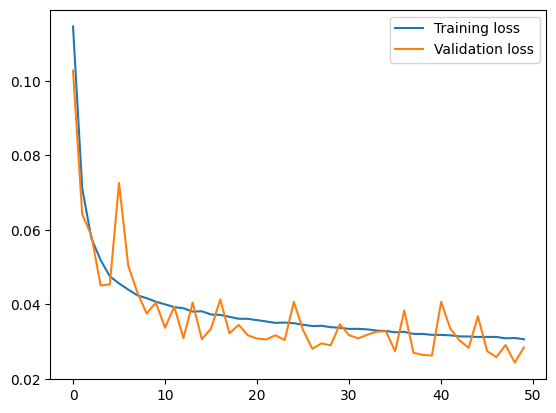

In [ ]:
plt.plot(history_BiLSTM_tuned_first.history['loss'], label='Training loss')
plt.plot(history_BiLSTM_tuned_first.history['val_loss'], label='Validation loss')
plt.legend()

In [ ]:
pred_BiLSTM_tuned_first = model_BiLSTM_tuned_first.predict(X_test_first)

51/51 [==============================] - 3s 28ms/step


In [ ]:
prediction_copies = np.repeat(pred_BiLSTM_tuned_first, 70, axis=-1)
pred_BiLSTM_tuned_unscaled_first = scaler_first.inverse_transform(prediction_copies)[:,-1]

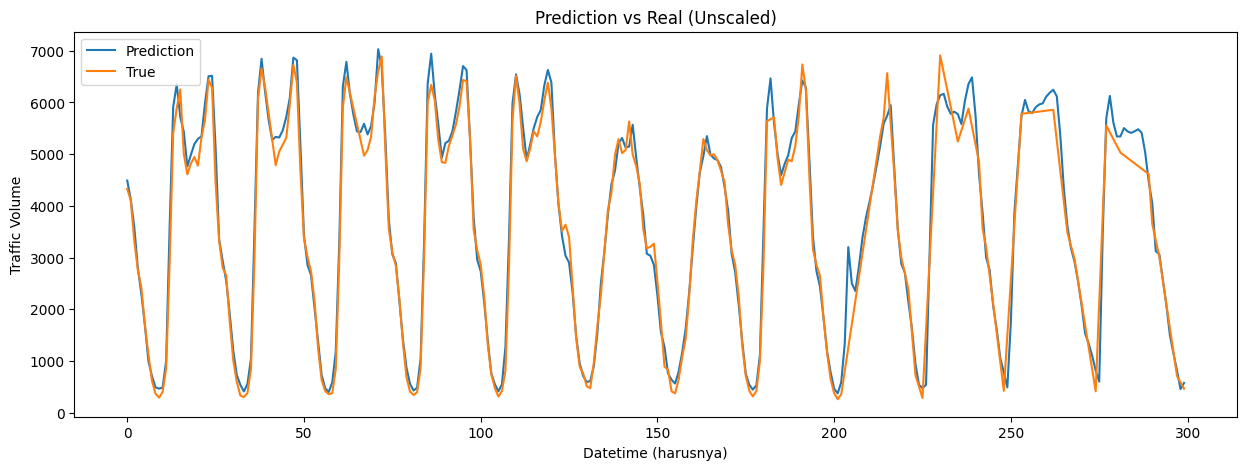

In [ ]:
# Plot Prediction vs Real Data
plt.figure(figsize=(15,5))
plt.plot(pred_BiLSTM_tuned_unscaled_first[:300])
plt.plot(true_value_first[:300])
plt.title('Prediction vs Real (Unscaled)')
plt.xlabel('Datetime (harusnya)')
plt.ylabel('Traffic Volume')
plt.legend(['Prediction','True'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error

mae_tuned_BiLSTM = mean_absolute_error(pred_BiLSTM_tuned_unscaled_first, true_value_first)
print(mae_tuned_BiLSTM)

201.8316538757963


## Second Half Dataset

In [12]:
from kerastuner.tuners import RandomSearch

def build_model_BiLSTM_second(hp):
    model = Sequential()
    model.add(Bidirectional(LSTM(hp.Int('units_layer1', min_value=32, max_value=128, step=32),
                                activation=hp.Choice('activation', values=['relu', 'tanh']),
                                input_shape=(trainX_second.shape[1], trainX_second.shape[2]),
                                return_sequences=True)))
    model.add(Bidirectional(LSTM(hp.Int('units_layer2', min_value=16, max_value=64, step=16), activation='relu')))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(trainY_second.shape[1]))
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop']),
                  loss='mae')
    return model

C:\Users\Naufal\AppData\Local\Temp\ipykernel_15080\2754179919.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [13]:
tuner_BiLSTM = RandomSearch(
    build_model_BiLSTM_second,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='model/BiLSTM_second_v2',
    project_name='BiLSTM_tuning_second_v2'
)

tuner_BiLSTM.search(X_train_second, y_train_second, epochs=10, validation_data=(X_test_second, y_test_second))

Trial 10 Complete [00h 09m 10s]
val_loss: 0.036853231489658356

Best val_loss So Far: 0.03073163516819477
Total elapsed time: 01h 18m 49s


In [14]:
# Get the optimal hyperparameters
best_hps_BiLSTM_second = tuner_BiLSTM.get_best_hyperparameters(num_trials=1)[0]

for param in best_hps_BiLSTM_second.values:
    print(param, best_hps_BiLSTM_second.get(param))

units_layer1 32
activation tanh
units_layer2 64
dropout 0.1
optimizer adam


In [15]:
# Build the model with the best hyperparameters
model_BiLSTM_tuned_second = tuner_BiLSTM.hypermodel.build(best_hps_BiLSTM_second)
history_BiLSTM_tuned_second = model_BiLSTM_tuned_second.fit(trainX_second, trainY_second, epochs=50, validation_data=(X_test_second, y_test_second))

Epoch 1/50
529/529 [==============================] - 20s 24ms/step - loss: 0.1073 - val_loss: 0.0738
Epoch 2/50
529/529 [==============================] - 13s 24ms/step - loss: 0.0627 - val_loss: 0.0517
Epoch 3/50
529/529 [==============================] - 12s 23ms/step - loss: 0.0514 - val_loss: 0.0461
Epoch 4/50
529/529 [==============================] - 11s 21ms/step - loss: 0.0444 - val_loss: 0.0337
Epoch 5/50
529/529 [==============================] - 11s 22ms/step - loss: 0.0418 - val_loss: 0.0325
Epoch 6/50
529/529 [==============================] - 11s 21ms/step - loss: 0.0400 - val_loss: 0.0397
Epoch 7/50
529/529 [==============================] - 11s 22ms/step - loss: 0.0391 - val_loss: 0.0302
Epoch 8/50
529/529 [==============================] - 11s 21ms/step - loss: 0.0383 - val_loss: 0.0299
Epoch 9/50
529/529 [==============================] - 11s 21ms/step - loss: 0.0370 - val_loss: 0.0415
Epoch 10/50
529/529 [==============================] - 11s 22ms/step - loss: 0.036

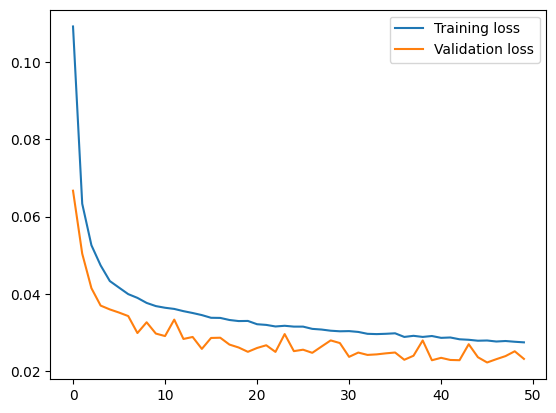

In [18]:
plt.plot(history_BiLSTM_tuned_second.history['loss'], label='Training loss')
plt.plot(history_BiLSTM_tuned_second.history['val_loss'], label='Validation loss')
plt.legend()

In [16]:
pred_BiLSTM_tuned_second = model_BiLSTM_tuned_second.predict(X_test_second)

53/53 [==============================] - 2s 8ms/step


In [20]:
trainX_second.shape

(16924, 24, 69)

In [21]:
prediction_copies = np.repeat(pred_BiLSTM_tuned_second, 69, axis=-1)
pred_BiLSTM_tuned_unscaled_second = scaler_second.inverse_transform(prediction_copies)[:,-1]

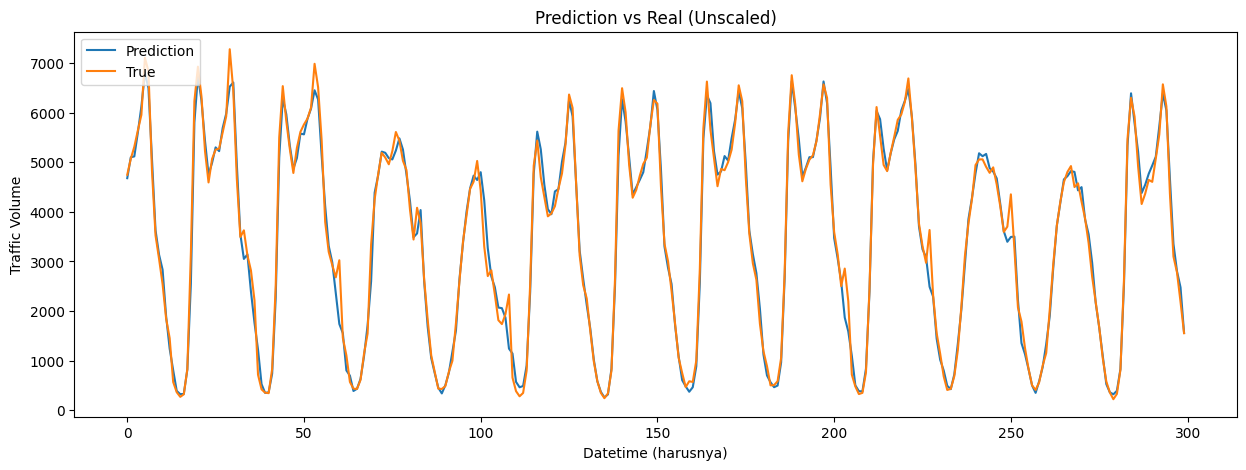

In [22]:
# Plot Prediction vs Real Data
plt.figure(figsize=(15,5))
plt.plot(pred_BiLSTM_tuned_unscaled_second[:300])
plt.plot(true_value_second[:300])
plt.title('Prediction vs Real (Unscaled)')
plt.xlabel('Datetime (harusnya)')
plt.ylabel('Traffic Volume')
plt.legend(['Prediction','True'], loc='upper left')
plt.show()

In [23]:
from sklearn.metrics import mean_absolute_error

mae_tuned_BiLSTM_second = mean_absolute_error(pred_BiLSTM_tuned_unscaled_second, true_value_second)
print(mae_tuned_BiLSTM_second)

166.36379259518455


In [24]:
model_BiLSTM_tuned_second.save('model/Tuned/BiLSTM_second_v2.h5')

c:\Users\Naufal\anaconda3\envs\XAI\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
